# Setup

In [1]:
!pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.2 MB/s eta 0:00:00


In [2]:
reddit_credentials = {
    'client_id': 'your client ID',
    'client_secret': 'your client secret',
    'password': 'your password',
    'username': 'your username',
    'user_agent': 'your user agent'
}

model_information = {
    'tokenizer':"./models/roberta_augmentation_label_spreading_after_pretraining_241123_tokenizer",
    'model':"./models/roberta_augmentation_label_spreading_after_pretraining_241123_model.pt",
    'threshold':0.93
}

In [3]:
# imports
import numpy as np
import os
import sys
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import re
import praw
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

root = 'your root folder/Reddit/'

os.chdir(root)
sys.path.append(root)


Mounted at /content/drive


# utils

In [4]:
from typing import List

class AntiIsraelAPI():
  def __init__(self, reddit_credentials, model_information, config):
    # Init a Reddit session
    self.reddit = praw.Reddit(**reddit_credentials, check_for_async=False)
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Load model
    self.tokenizer = RobertaTokenizer.from_pretrained(model_information['tokenizer'])
    self.model = RobertaForSequenceClassification.from_pretrained(
        model_information['model'],
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False
        ).to(self.device)
    self.model_information = model_information
    self.config = config

  def detect(self, subreddit_name, limit, relevant_terms, posts_type):
    """
    run the entire process
    """
    # create an empty dictionary to store results
    results = {
        'sentences':[],
        'comments_ids':[],
        'title_id':[],
        'inputs':[],
        'scores':[],
        'prediction':[]
        }

    # get related posts
    posts = self._subreddit_get_posts(subreddit_name, limit, relevant_terms, posts_type)
    print(f'There are {len(posts)} posts about Israel.')

    # process posts
    for post in tqdm(posts, desc='Processing posts'):
      try:
        post_dataloader, comments_and_sentences = self._process_post(post, subreddit_name)
        prediction_results = self.predict(post_dataloader)
        post_results = {**comments_and_sentences,**prediction_results}

        # update results
        for k in results.keys():
          # print(f'{k}, {len(post_results[k])}, {type(post_results[k])}')
          results[k]+=post_results[k]
      except:
        continue

    return results


  def _subreddit_get_posts(self, subreddit_name, limit, relevant_terms, posts_type)->List:
    subreddit = self.reddit.subreddit(subreddit_name)
    if posts_type == 'new':
      posts = subreddit.new(limit=limit)
    if posts_type == 'hot':
      posts = subreddit.hot(limit=limit)

    # filter out irrelevant posts
    relevant_posts = []
    for post in posts:
      terms_included = 0
      title = str.lower(post.title).replace(f'/r/{subreddit_name} ','')
      for term in relevant_terms:
        if term in title and terms_included == 0:
          relevant_posts.append(post)
          terms_included+=1
        else:
          continue

    return relevant_posts

  def _process_post(self, post, subreddit_name)->DataLoader:
    # extract content from post
    post_and_comments = AntiIsraelAPI._post_get_comments_and_ids(post)

    # get title and comments
    post_title  = post_and_comments['title_text'][0].replace(f'/r/{subreddit_name} ','')
    post_id  = post_and_comments['title_id'][0]
    comments    = post_and_comments['comments_text']
    comments_ids= post_and_comments['comments_id']

    # duplicate `post_id`
    post_id = [post_id]*len(comments_ids)

    # process (clean comments and join titles and comments)
    comments = [AntiIsraelAPI.remove_hyperlinks(x) for x in comments]
    comments = [AntiIsraelAPI.trimmer(x) for x in comments]
    sentences = np.array([f'{post_title} ; {comment}' for comment in comments])

    # store sentences and comments IDs
    sentences_and_comments_ids = {'sentences':sentences.tolist(),'comments_ids':comments_ids, 'title_id':post_id}

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        encoded_dict = self.tokenizer.encode_plus(
                            sent,                           # Sentence to encode.
                            add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                            max_length = 512,               # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',          # Return pytorch tensors.
                      )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors and then to torch dataset.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    dataset = TensorDataset(input_ids, attention_masks)

    # Create a dataloader
    dataloader = DataLoader(
        dataset,
        batch_size = 32
        )

    return dataloader, sentences_and_comments_ids

  def predict(self, dataloader):

    results = {
        'inputs':[],
        'scores':[]
        }

    for batch in dataloader:
      b_input_ids = batch[0].to(self.device)
      b_input_mask = batch[1].to(self.device)

      with torch.no_grad():
        scores = self.model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask)

        logits = scores.logits
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy().tolist()


        results['inputs'] += b_input_ids.tolist()
        results['scores'] += probs

    results['prediction'] = np.where(np.array(results['scores'])>self.model_information['threshold'],1,0).tolist()

    return results


  @staticmethod
  def _post_get_comments_and_ids(post)->dict:
    """
    Extract content from a Reddit submission.

    inputs:
    post: Reddit Submission(id='182j32m')

    output:
    - dictionary with post ID, post title, comments ID and comments texts.

    Example:
    _post_get_comments_and_ids(post)

    """
    results = {
        'title_text':[],
        'title_id':[],
        'comments_text':[],
        'comments_id':[]
        }

    results['title_text'].append(post.title)
    results['title_id'].append(post.id)

    comments = [x for x in post.comments]
    results['comments_text'] = [comments[j].body for j in range(len(comments)-1)]
    results['comments_id'] = [comments[j].id for j in range(len(comments)-1)]

    return results

  @staticmethod
  def remove_hyperlinks(text):
    """Removes hyperlinks from text.

    Args:
      text: A string containing the text with hyperlinks.

    Returns:
      A string containing the text without hyperlinks.
    """
    # replace http to https
    text = text.replace('http://', 'https://')

    # Remove embedded hyperlinks.
    text = re.sub(r'\[(.*?)\]\(https:\/\/.*?\)', r'\1', text)

    # Remove pasted hyperlinks.
    text = re.sub(r'https?://\S+', '', text)

    return text

  @staticmethod
  def count_hyperlinks(text):
    """Counts the number of hyperlinks in text.

    Args:
      text: A string containing the text with hyperlinks.

    Returns:
      An integer representing the number of hyperlinks in the text.
    """
    # replace http to https
    text = text.replace('http://', 'https://')

    # Count embedded hyperlinks.
    hyperlinks = re.findall(r'https:\/\/.*?', text)

    # Return the total number of hyperlinks.
    return len(hyperlinks)

  @staticmethod
  def trimmer(text):
    """Removes extra characters in a row from text.
    """
    # remove trailing spaces
    lines = text.splitlines()

    # Remove trailing spaces from each line.
    clean_lines = [line.rstrip() for line in lines]

    # Join the lines back into a string.
    text = "\n".join(clean_lines)

    # Remove newlines in a row that have only one character in them.
    text = re.sub(r'\n\s*\n+', '\n\n', text)

    # Remove extra spaces in a row.
    text = re.sub(r'\s+', ' ', text)

    # Remove multiple blank lines.
    text = re.sub(r'\n\s*\n+', '\n\n', text)

    # Remove unnecessary whitespace.
    text = re.sub(r'\s+', ' ', text)

    # Remove extra dashes in a row.
    text = re.sub(r'--+', '--', text)

    # remove more than one \n in a row
    text = re.sub(r'\n+', '\n', text)

    # Compile the patterns into a regular expression.
    substrings = ['- ', '* ', ' -', ' *']
    for substring in substrings:
      text = text.replace(substring, '')

    return text


# WorldNews

In [16]:
config = {
    'limit':1000,
    'subreddit_name':'WorldNews',
    'relevant_terms':{'israel', 'hammas', 'palestine'},
    'posts_type':'new',

}

ant = AntiIsraelAPI(reddit_credentials,model_information,config)
results = ant.detect(**config)

print('\nNum of Results:')
for k in results.keys():
  print(f'\t{k}: {len(results[k])}')


There are 68 posts about Israel.


Processing posts:   1%|▏         | 1/68 [00:00<00:28,  2.34it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing posts: 100%|██████████| 


Num of Results:
	sentences: 1320
	comments_ids: 1320
	title_id: 1320
	inputs: 1320
	scores: 1320
	prediction: 1320


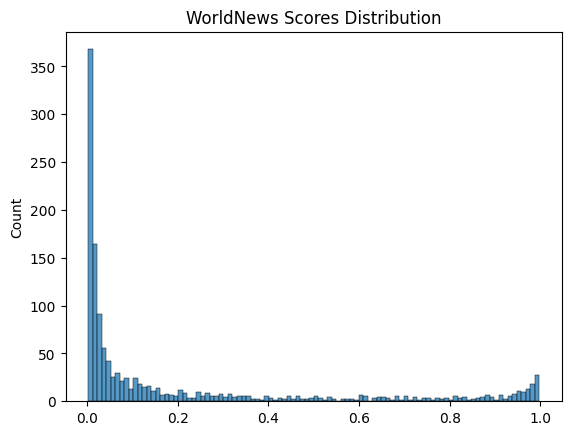

In [17]:
positive_preds = np.array(results['scores'])[:,1]

sns.histplot(positive_preds, bins = 100)
plt.title('WorldNews Scores Distribution')
plt.show()


In [18]:
# Present comments
threshold = 0.93
positive_mask = positive_preds>threshold
print(f'Anti Israeli Comments: {sum(positive_mask)}')

indices = np.random.randint(0,sum(positive_mask),5)

print('-----')
print('')
print('Anti-israel comments:')
print(np.array(results['sentences'])[positive_mask])
print('-----')


Anti Israeli Comments: 91
-----

Anti-israel comments:
["Israeli Hostages’ Family Members Are Being Threatened By Suspicious Texts ; Clownishly evil. I can't wait for the day when all the people supporting this behavior are forced to come to terms with the practices they've defended."
 'Released Thai hostage says Israelis held with him were beaten with electric cables ; Beating civilian hostages with power cables is legitimate resistance. /s /far too many fucktards'
 'Released Thai hostage says Israelis held with him were beaten with electric cables ; Classical anticolonial hostage torture... /s'
 'Released Thai hostage says Israelis held with him were beaten with electric cables ; HAMAS EAT 🐷💩'
 'Released Thai hostage says Israelis held with him were beaten with electric cables ; Obviously this is not true, Thai are part of the Western colonialism and Zionism! Liars!'
 'Released Thai hostage says Israelis held with him were beaten with electric cables ; What did Israel expect would ha

# News

In [9]:
config = {
    'limit':1000,
    'subreddit_name':'News',
    'relevant_terms':{'israel', 'hamas', 'palestine', 'gaza', 'west bank'},
    'posts_type':'new',

}

ant = AntiIsraelAPI(reddit_credentials,model_information,config)
results = ant.detect(**config)

print('\nNum of Results:')
for k in results.keys():
  print(f'\t{k}: {len(results[k])}')


There are 10 posts about Israel.


Processing posts:  10%|█         | 1/10 [00:00<00:03,  2.54it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing posts: 100%|██████████| 


Num of Results:
	sentences: 292
	comments_ids: 292
	title_id: 292
	inputs: 292
	scores: 292
	prediction: 292


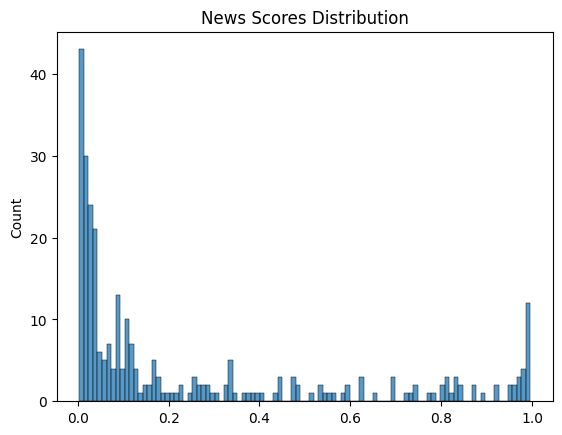

In [11]:
positive_preds = np.array(results['scores'])[:,1]

sns.histplot(positive_preds, bins = 100)
plt.title('News Scores Distribution')
plt.show()


In [12]:
# Present comments
threshold = 0.93
positive_mask = positive_preds>threshold
print(f'Anti Israeli Comments: {sum(positive_mask)}')

indices = np.random.randint(0,sum(positive_mask),5)

print('-----')
print('')
print('Anti-israel comments:')
print(np.array(results['sentences'])[positive_mask])
print('-----')


Anti Israeli Comments: 23
-----

Anti-israel comments:
["Israel releases 30 Palestinian prisoners on fifth day of temporary cease-fire ; How did Israel even get the prisoners... which is mostly women and children .....were they planning on keeping and torturing them if it wasn't for the exchange..."
 "Israel and Hamas agree to extend truce for two more days, and free more hostages and prisoners ; Thankful for that at least. we'll never shut up until it's a lasting ceasefire, an end to netanyahu's rule, and real negotiations for full enfranchisement of palestinians."
 "Israel and Hamas agree to extend truce for two more days, and free more hostages and prisoners ; How did Israel even get the prisoners... which is mostly women and children .....were they planning on keeping and torturing them if it wasn't for the exchange..."
 'US Navy seizes attackers who held Israel-linked tanker ; dont fuck with the boats, USN does not like it when you fuck with the boats, and loves the opportunity to

# neutralnews

In [13]:
config = {
    'limit':1000,
    'subreddit_name':'neutralnews',
    'relevant_terms':{'israel', 'hamas', 'palestine', 'gaza', 'west bank'},
    'posts_type':'new',

}

ant = AntiIsraelAPI(reddit_credentials,model_information,config)
results = ant.detect(**config)

print('\nNum of Results:')
for k in results.keys():
  print(f'\t{k}: {len(results[k])}')


There are 89 posts about Israel.


Processing posts:   0%|          | 0/89 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing posts: 100%|██████████| 89/89 [0


Num of Results:
	sentences: 185
	comments_ids: 185
	title_id: 185
	inputs: 185
	scores: 185
	prediction: 185


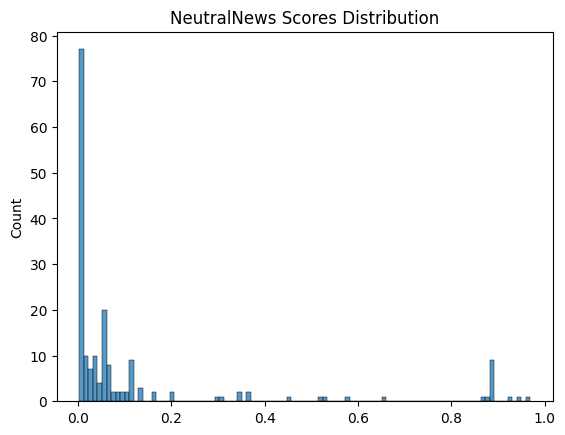

In [14]:
positive_preds = np.array(results['scores'])[:,1]

sns.histplot(positive_preds, bins = 100)
plt.title('NeutralNews Scores Distribution')
plt.show()


In [15]:
# Present comments
threshold = 0.93
positive_mask = positive_preds>threshold
print(f'Anti Israeli Comments: {sum(positive_mask)}')

indices = np.random.randint(0,sum(positive_mask),5)

print('-----')
print('')
print('Anti-israel comments:')
print(np.array(results['sentences'])[positive_mask])
print('-----')


Anti Israeli Comments: 2
-----

Anti-israel comments:
['The US tells Israel any ground campaign in southern Gaza must limit further civilian displacement ; "Significant further displacement" couldn\'t be a more toothless, non-binding phrase. And the U.S. tells Israel that it "must" do this....or else what?'
 'Opinion: I’m an expert in urban warfare. Israel is upholding the laws of war | CNN ; I like that he wants to compare what is happening to the war crimes he himself committed as a U.S soldier in Iraq. "If we did it is not a war crime", is the ultimate American argument lol.']
-----
